In [29]:
suppressPackageStartupMessages({
  library(MOFA2)
  library(ggplot2)
})

In [30]:
my_multiomics <- readRDS("/home/vik/RSU_work/CAD-omics/data/processed/stability_multiomics_imputed.rds")

# Extract omics blocks
data_list <- list(
  miRNA           = as.matrix(my_multiomics$data$mirna),
  SNP             = as.matrix(my_multiomics$data$snp),
  Clinical_cont   = as.matrix(my_multiomics$data$clinical_cont),
  Clinical_binary = as.matrix(my_multiomics$data$clinical_binary)
)


### 2. Clean and match samples

In [31]:
# Filter out samples with all NA per block
data_list <- lapply(data_list, function(x) x[complete.cases(x), , drop = FALSE])

# Get intersecting sample names
common_samples <- Reduce(intersect, lapply(data_list, rownames))
#common_samples <- Reduce(union, lapply(data_list, rownames))
# Subset data blocks
data_list <- lapply(data_list, function(x) x[common_samples, , drop = FALSE])

# Prepare sample labels (status)
status <- my_multiomics$data$status
names(status) <- rownames(my_multiomics$data$mirna)
status <- status[common_samples]
status <- droplevels(status)
status_labels <- as.character(status)

# Check dimensions
cat("Sample sizes per block:\n")
print(lapply(data_list, dim))
cat("Status table:\n")
print(table(status))

Sample sizes per block:
$miRNA
[1]  33 183

$SNP
[1]  33 189

$Clinical_cont
[1] 33 36

$Clinical_binary
[1] 33  8

Status table:
status
 0  1 
21 12 


In [3]:
# Filter out samples with all NA per block
#data_list <- lapply(data_list, function(x) x[complete.cases(x), , drop = FALSE])

# Get intersecting sample names
common_samples <- Reduce(intersect, lapply(data_list, rownames))
#common_samples <- Reduce(union, lapply(data_list, rownames))
# Subset data blocks
data_list <- lapply(data_list, function(x) x[common_samples, , drop = FALSE])

# Prepare sample labels (status)
status <- my_multiomics$data$status
names(status) <- rownames(my_multiomics$data$mirna)
status <- status[common_samples]
status <- droplevels(status)
status_labels <- as.character(status)

# Check dimensions
cat("Sample sizes per block:\n")
print(lapply(data_list, dim))
cat("Status table:\n")
print(table(status))

Sample sizes per block:
$miRNA
[1]  67 183

$SNP
[1]  67 189

$Clinical_cont
[1] 67 36

$Clinical_binary
[1] 67  8

Status table:
status
 0  1 
35 32 


In [32]:
# MOFA expects features x samples. If you currently have samples x features, transpose.
transpose_if_needed <- function(M) {
  if (!is.null(rownames(M)) && nrow(M) == length(common_samples)) {
    # likely samples x features -> transpose to features x samples
    TM <- t(M)
    colnames(TM) <- rownames(M)
    rownames(TM) <- colnames(M)
    return(TM)
  } else {
    return(M)
  }
}
data_list <- lapply(data_list, transpose_if_needed)

cat("Sample sizes per block:\n")
print(lapply(data_list, dim))

Sample sizes per block:
$miRNA
[1] 183  33

$SNP
[1] 189  33

$Clinical_cont
[1] 36 33

$Clinical_binary
[1]  8 33



### 3. Build MOFA model

In [33]:
multiomics_list <- list(
  miRNA               = data_list$miRNA,            # continuous
  SNPs                = data_list$SNP,              # 0/1/2 dosage -> gaussian is fine
  Clinical_continuous = data_list$Clinical_cont,    # continuous
  Clinical_binary     = data_list$Clinical_binary   # binary (0/1)
)


In [34]:
MOFAobject <- create_mofa(multiomics_list)
# Define likelihoods per view
model_opts <- get_default_model_options(MOFAobject)
model_opts$num_factors <- 10
model_opts$likelihoods <- c(
  miRNA = "gaussian",
  SNPs = "gaussian",
  Clinical_continuous = "gaussian",
  Clinical_binary = "bernoulli"
)

# Set data/training options
data_opts <- get_default_data_options(MOFAobject)
train_opts <- get_default_training_options(MOFAobject)
train_opts$seed <- 42
train_opts$maxiter <- 1000

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




### 4. Prepare + Train MOFA

In [35]:
MOFAobject <- prepare_mofa(
  MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
)

MOFAmodel <- run_mofa(MOFAobject, use_basilisk = TRUE)

Warning message in prepare_mofa(MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...

Warning message in prepare_mofa(MOFAobject, data_options = data_opts, model_options = model_opts, :
“The total number of samples is very small for learning 10 factors.  
    Try to reduce the number of factors to obtain meaningful results. It should not exceed ~8.”
Warning message in run_mofa(MOFAobject, use_basilisk = TRUE):
“No output filename provided. Using /tmp/RtmpzemiAD/mofa_20250814-093414.hdf5 to store the trained model.

”
Connecting to the mofapy2 package using basilisk. 
    Set 'use_basilisk' to FALSE if you prefer to manually set the python binary using 'reticulate'.

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 1 are strongly correlated wit

### 5. Evaluate model

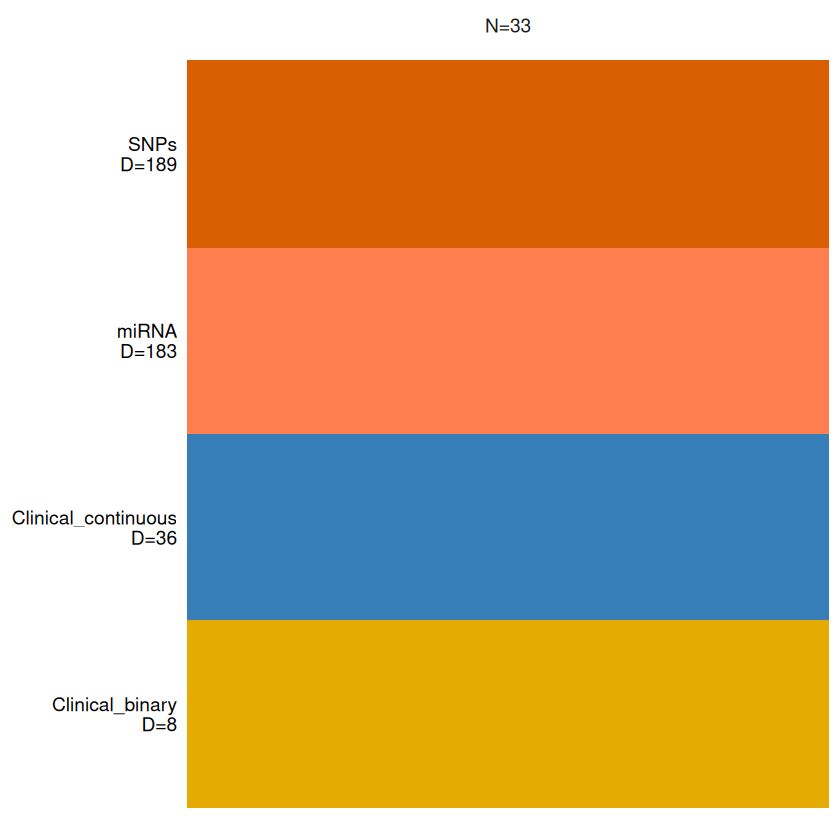

In [36]:
plot_data_overview(MOFAobject)


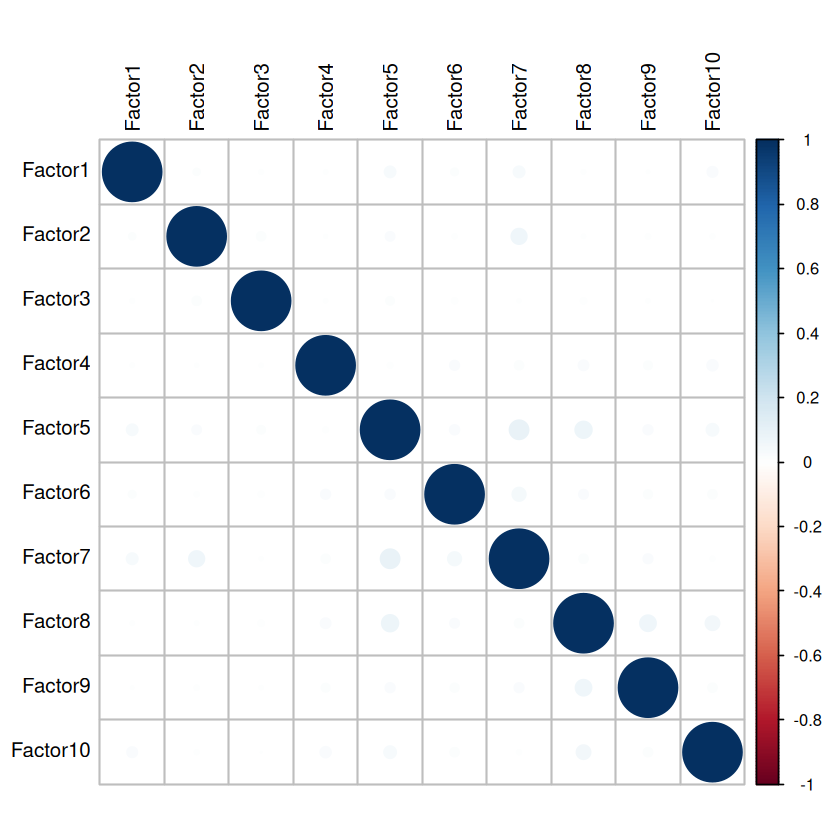

In [9]:
plot_factor_cor(MOFAmodel)


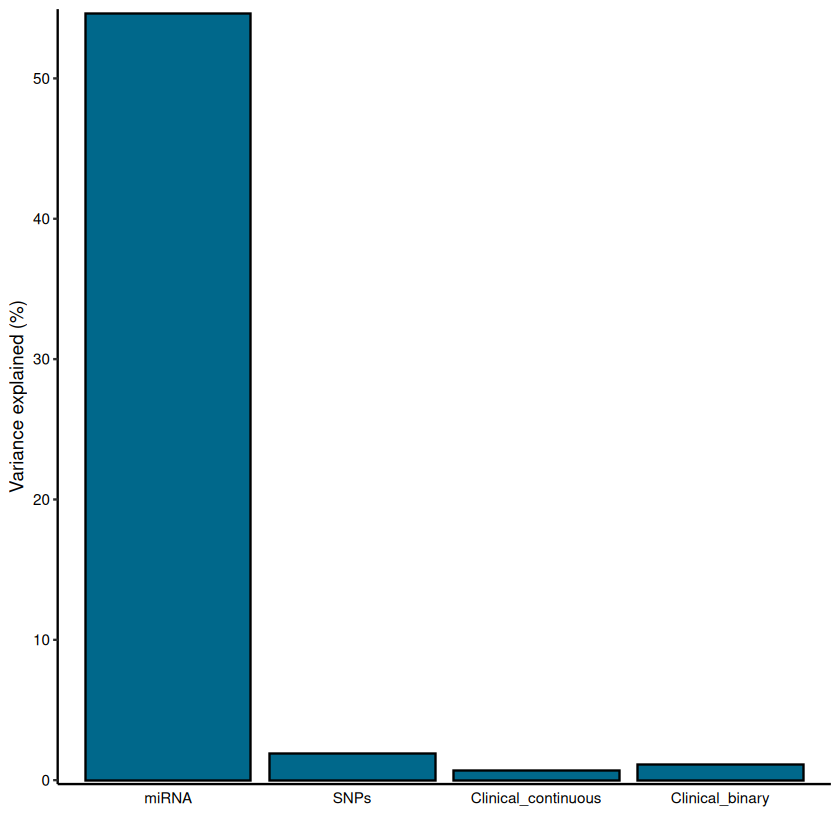

In [10]:
plot_variance_explained(MOFAmodel, plot_total = TRUE)[[2]]


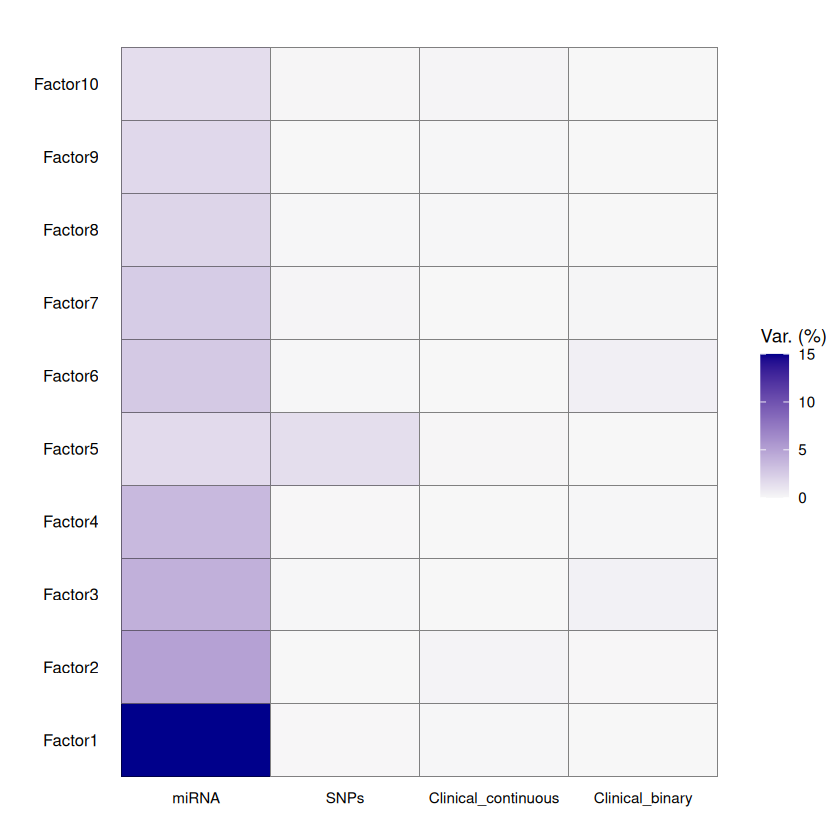

In [11]:
plot_variance_explained(MOFAmodel, max_r2 = 15)


### miRNA Factor 1

In [12]:
# Get top features for a given factor
top_mirna <- get_weights(MOFAmodel, view = "miRNA", factor = 1, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)

top_mirna


,feature,factor,value,view
,<fct>,<fct>,<dbl>,<fct>
1,hsa-miR-192-5p,Factor1,-2.678213,miRNA
2,hsa-miR-106b-3p,Factor1,-2.423987,miRNA
3,hsa-miR-3615,Factor1,-2.250210,miRNA
4,hsa-miR-3158-3p,Factor1,-2.145588,miRNA
5,hsa-miR-183-5p,Factor1,-2.126718,miRNA
6,hsa-miR-29c-3p,Factor1,-2.102943,miRNA
7,hsa-miR-584-5p,Factor1,-2.096786,miRNA
8,hsa-miR-375-3p,Factor1,-2.059621,miRNA
9,hsa-miR-185-5p,Factor1,-2.042097,miRNA


### SNP Factor 5

In [13]:
# Get top features for a given factor
top_snp <- get_weights(MOFAmodel, view = "SNPs", factor = 5, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)

top_snp


,feature,factor,value,view
,<fct>,<fct>,<dbl>,<fct>
1,rs4537761,Factor5,0.16087054,SNPs
2,rs112238647,Factor5,-0.10974503,SNPs
3,rs11663411,Factor5,0.10153621,SNPs
4,rs6740731,Factor5,0.10135479,SNPs
5,rs9515203,Factor5,0.09981331,SNPs
6,rs56195640,Factor5,0.09646460,SNPs
7,rs10930115,Factor5,-0.09298907,SNPs
8,rs73596816,Factor5,-0.08650973,SNPs
9,rs60154123,Factor5,-0.08632509,SNPs


### Clinical continuous Factor 2

In [14]:
# Get top features for a given factor
top_Clinical_continuous <- get_weights(MOFAmodel, view = "Clinical_continuous", factor = 2, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)

top_Clinical_continuous


,feature,factor,value,view
,<fct>,<fct>,<dbl>,<fct>
1,Target_lipidic,Factor2,-0.020757182,Clinical_continuous
2,Plaque_necrolipidic_tissue,Factor2,-0.018971751,Clinical_continuous
3,Target_necrotic,Factor2,-0.018474128,Clinical_continuous
4,Target_fibrotic,Factor2,0.018136345,Clinical_continuous
5,MO_abs,Factor2,0.014761025,Clinical_continuous
6,Eo_Abs,Factor2,0.014026144,Clinical_continuous
7,RBC,Factor2,-0.013177058,Clinical_continuous
8,BMI,Factor2,0.012747114,Clinical_continuous
9,NE_abs,Factor2,-0.010110373,Clinical_continuous


### Clinical binary Factor 3

In [15]:
top_Clinical_binary <- get_weights(MOFAmodel, view = "Clinical_binary", factor = 3, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)

top_Clinical_binary

,feature,factor,value,view
,<fct>,<fct>,<dbl>,<fct>
1,Smoking_1,Factor3,0.0363120846,Clinical_binary
2,Smoking_2,Factor3,-0.0345027559,Clinical_binary
3,Previous_PCI,Factor3,-0.0342542939,Clinical_binary
4,Congestive_heart_failure,Factor3,-0.0181635767,Clinical_binary
5,Positive_family_history,Factor3,-0.0129806446,Clinical_binary
6,Previous_MI,Factor3,-0.0110691544,Clinical_binary
7,Art_hipert,Factor3,0.0040861308,Clinical_binary
8,Sex,Factor3,-0.0001766711,Clinical_binary


In [16]:
# Get sample names from MOFA model
samples_in_model <- samples_names(MOFAmodel)[[1]]

# Extract and match status from original multiomics object
status_vec <- my_multiomics$data$status
names(status_vec) <- rownames(my_multiomics$data$mirna)

# Subset and align to MOFA sample order
status_vec <- status_vec[samples_in_model]

# Double-check matching
stopifnot(length(status_vec) == length(samples_in_model))

# Create metadata
metadata <- data.frame(
  sample = samples_in_model,
  status = as.factor(status_vec),
  row.names = samples_in_model
)

# Attach to MOFA model
samples_metadata(MOFAmodel) <- metadata


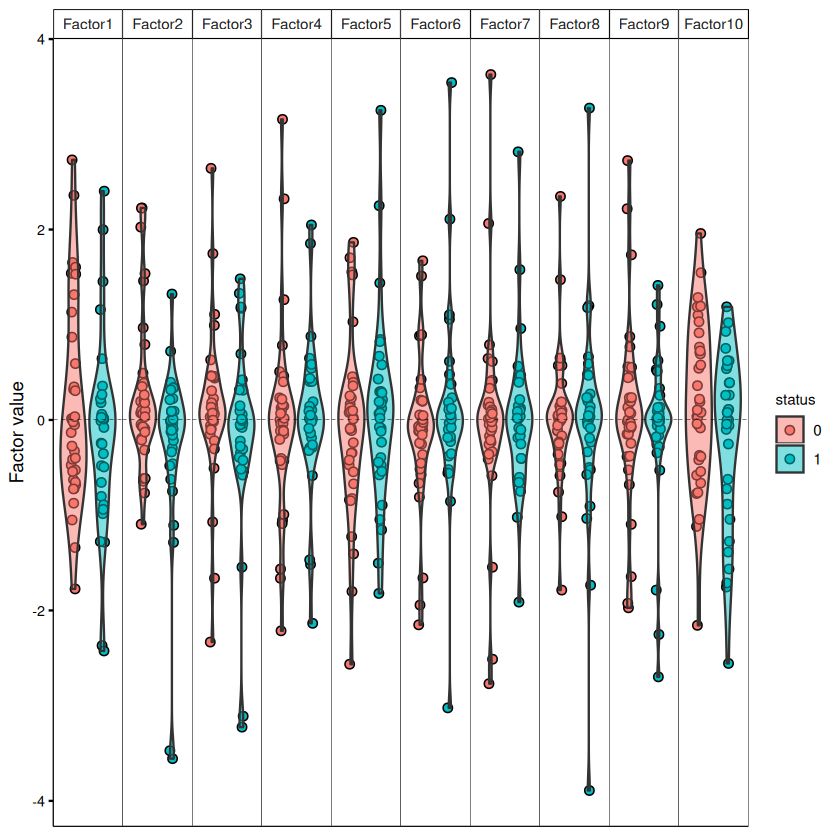

In [17]:
# Violin plot for all factors
plot_factor(
  MOFAmodel,
  factors = 1:10,
  color_by = "status",
  add_violin = TRUE,
  dodge = TRUE
)


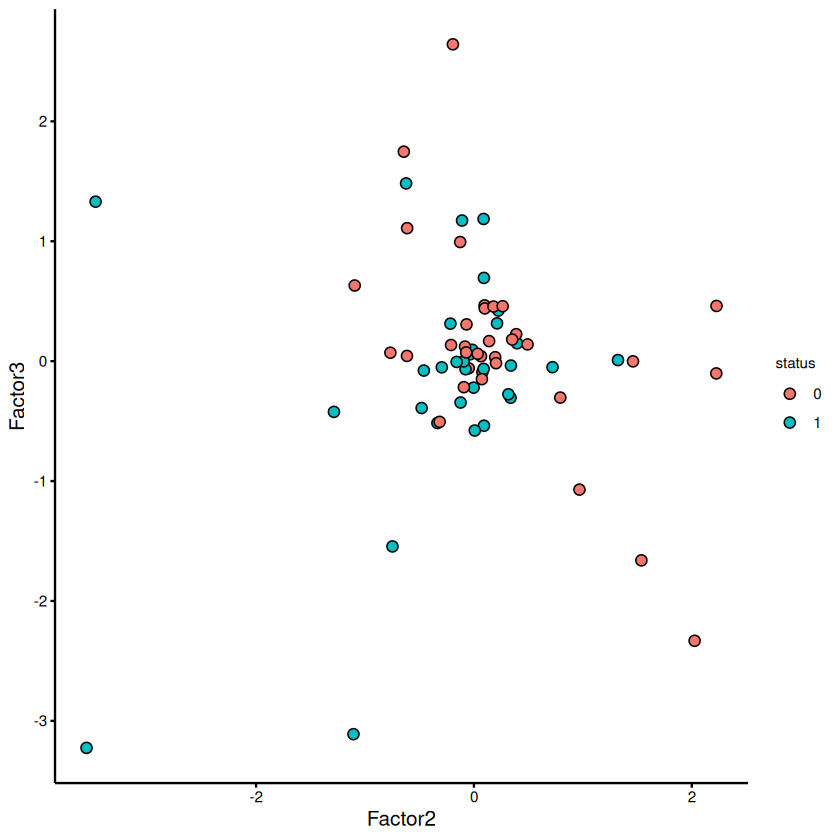

In [20]:
plot_factors(MOFAmodel, 
             factors = c(2, 3), 
             color_by = "status", 
             dot_size = 2.5,
             show_missing = TRUE)

In [19]:
library(ggpubr)

factors <- get_factors(MOFAmodel)[[1]]
wilcox_pvals <- apply(factors, 2, function(fac) {
  wilcox.test(fac ~ metadata$status)$p.value
})

# Print and adjust p-values
print(wilcox_pvals)
#print(p.adjust(wilcox_pvals, method = "fdr"))


   Factor1    Factor2    Factor3    Factor4    Factor5    Factor6    Factor7 
0.57025767 0.06757945 0.08210545 0.51236201 0.51236201 0.44263239 0.77904561 
   Factor8    Factor9   Factor10 
0.89584551 0.83700234 0.16647777 


In [21]:
top_miRNAs <- get_weights(MOFAmodel, view = "miRNA", factor = 2, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)


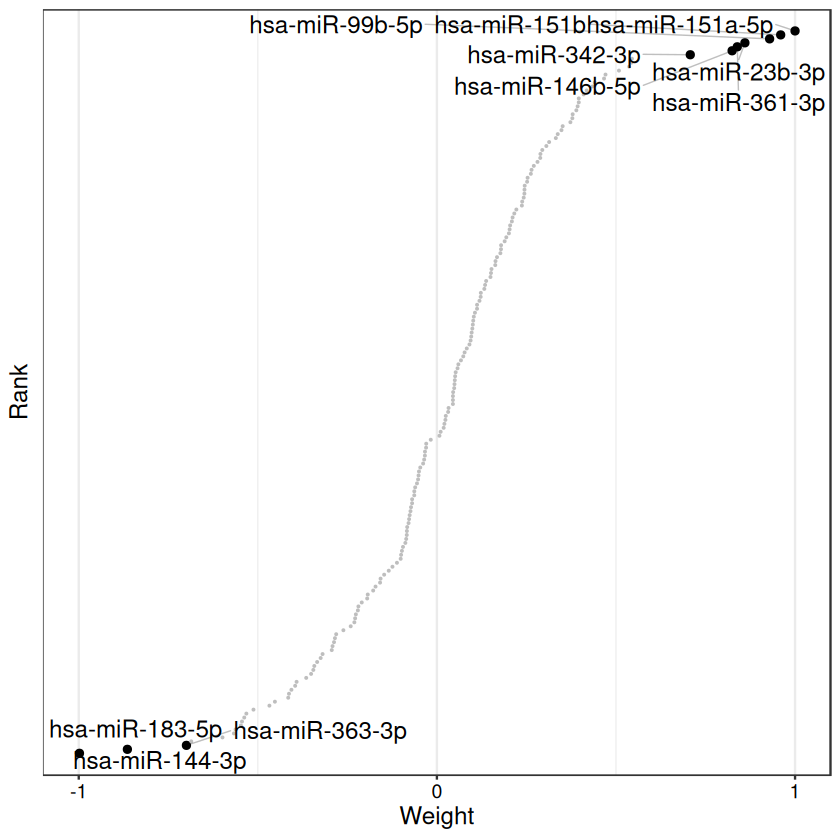

In [22]:
plot_weights(MOFAmodel, view = "miRNA", factor = 2, nfeatures = 10, scale = TRUE)


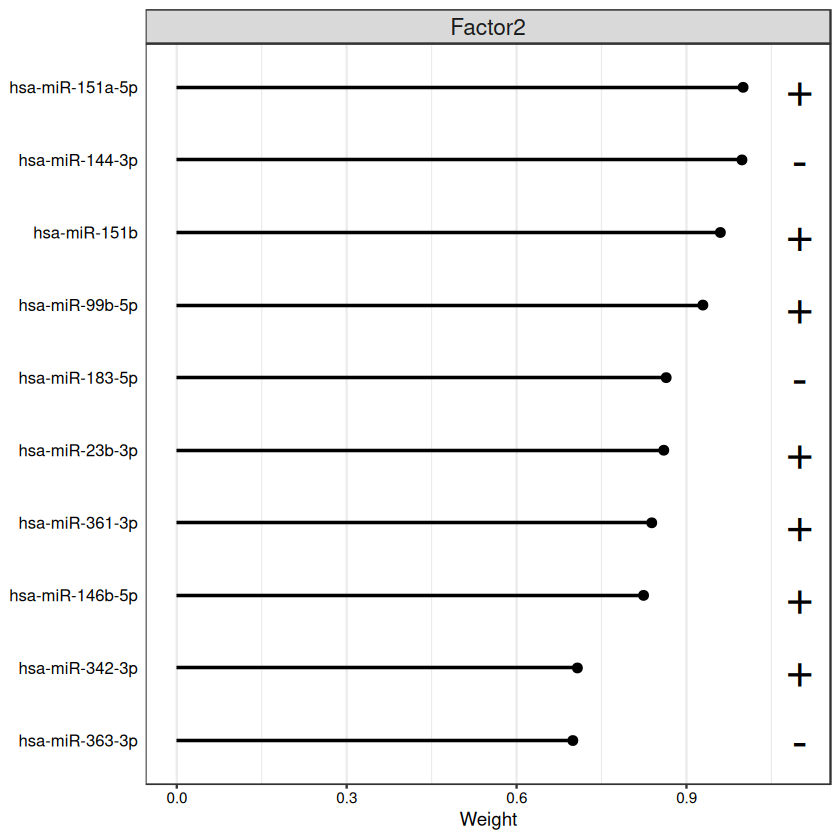

In [23]:
plot_top_weights(MOFAmodel, view = "miRNA", factor = 2, nfeatures = 10, scale = TRUE)


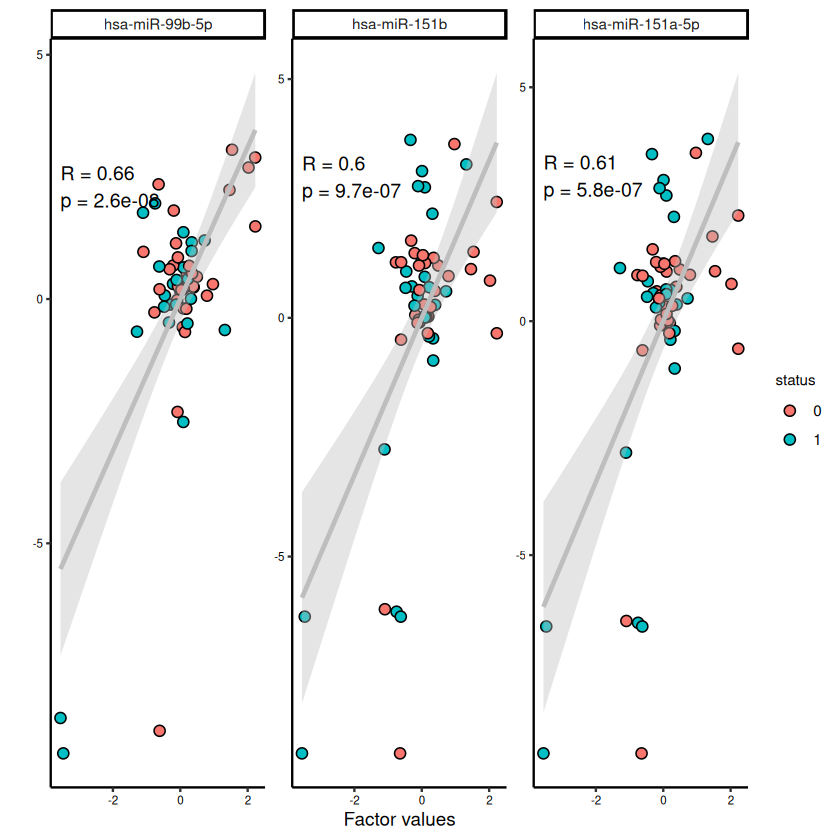

In [24]:
plot_data_scatter(MOFAmodel, view = "miRNA", factor = 2, features = 3, sign = "positive", color_by = "status")


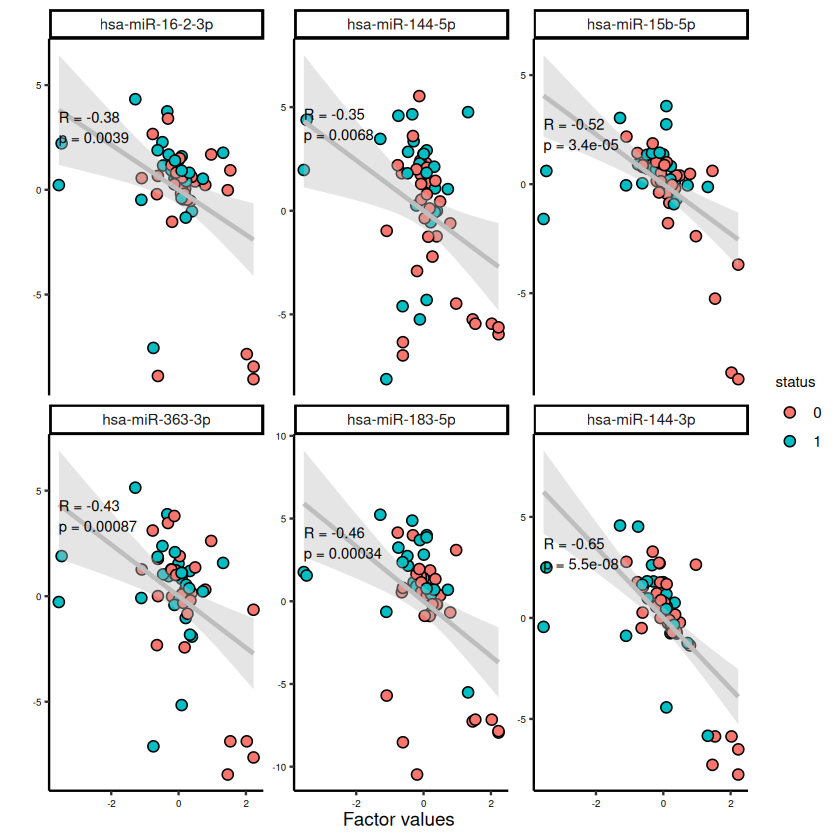

In [25]:
plot_data_scatter(MOFAmodel, view = "miRNA", factor = 2, features = 6, sign = "negative", color_by = "status")


In [26]:
top_SNPs <- get_weights(MOFAmodel, view = "SNPs", factor = 2, as.data.frame = TRUE) |>
  dplyr::arrange(desc(abs(value))) |>
  head(20)

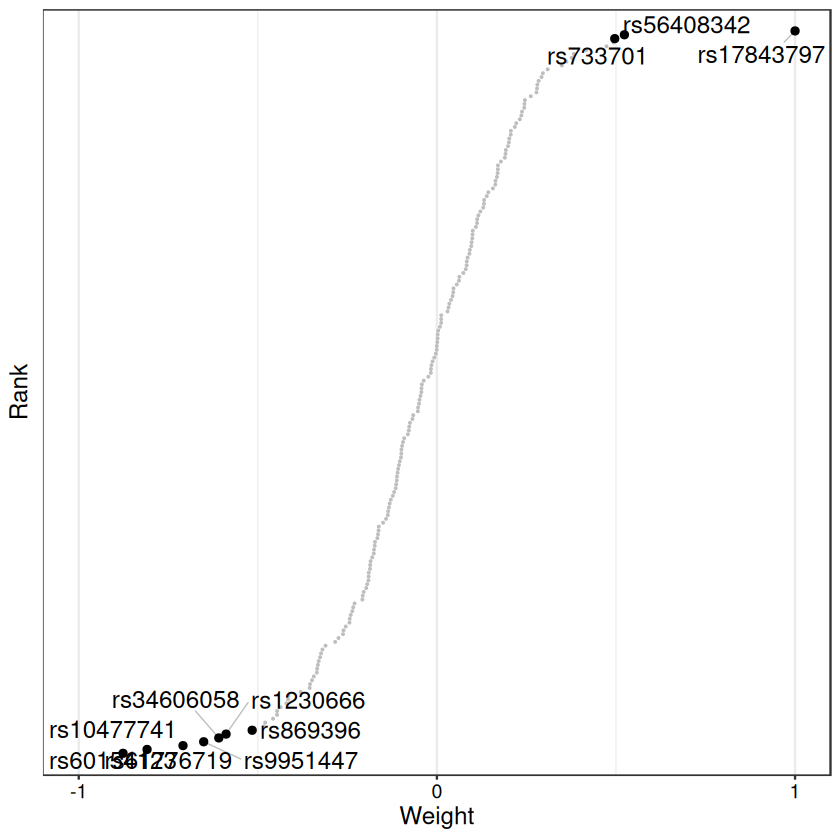

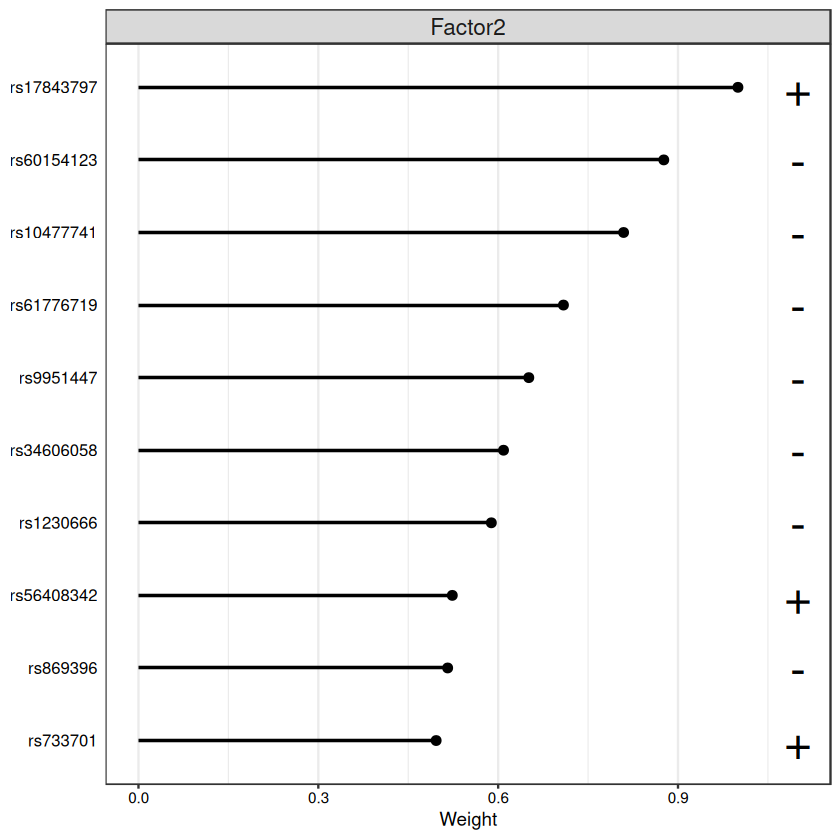

In [27]:
plot_weights(MOFAmodel, view = "SNPs", factor = 2, nfeatures = 10, scale = TRUE)
plot_top_weights(MOFAmodel, view = "SNPs", factor = 2, nfeatures = 10, scale = TRUE)

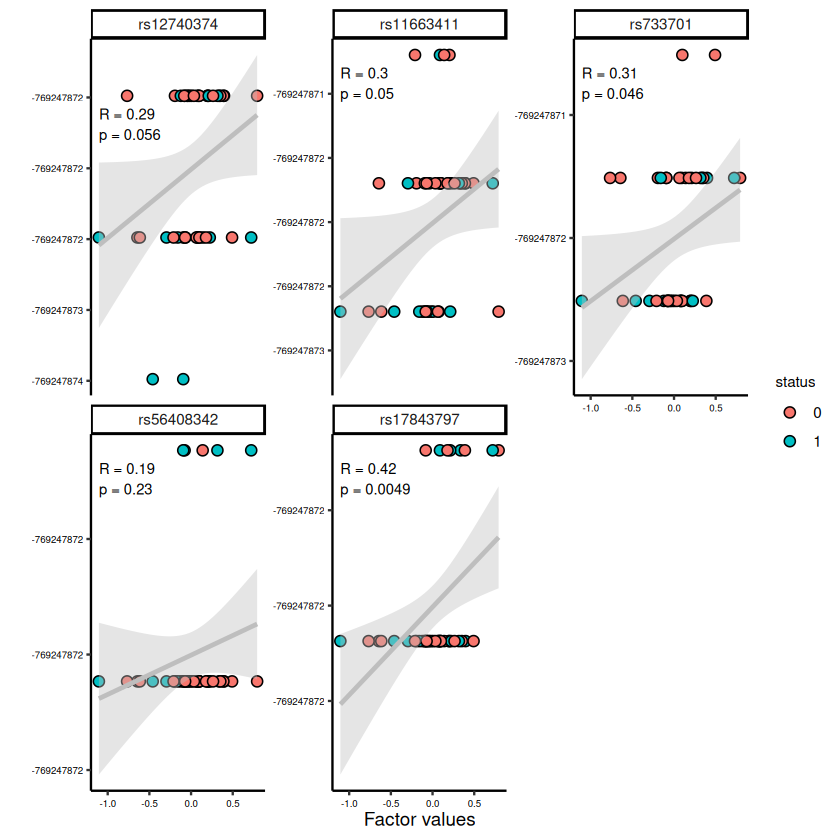

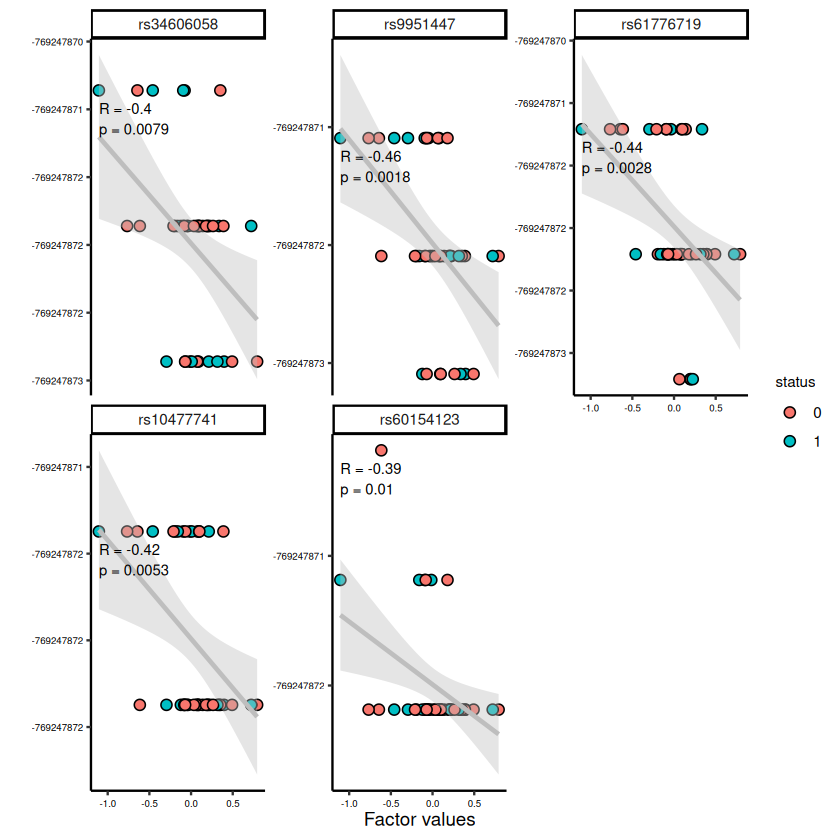

In [28]:
plot_data_scatter(MOFAmodel, view = "SNPs", factor = 2, features = 5, sign = "positive", color_by = "status")
plot_data_scatter(MOFAmodel, view = "SNPs", factor = 2, features = 5, sign = "negative", color_by = "status")
